In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
np.seterr(all="raise")

today = "2019-11-06"

df = pd.read_parquet(f"out/{today}-2d-test.parquet")
df["total_params1"] = df["shape1[0]"] * df["shape1[1]"]
df["total_params2"] = df["shape2[0]"] * df["shape2[1]"]
print(len(df))
df.tail()

73023


,shape1[0],shape2[0],shape1[1],shape2[1],mode,seed,fft_time,direct_time,total_params1,total_params2
73018,74,25,45,50,full,24339,0.000487,0.191245,3330,1250
73019,74,25,45,50,same,24339,0.000532,0.080625,3330,1250
73020,12,8,95,8,valid,24340,0.000313,0.000654,1140,64
73021,12,8,95,8,full,24340,0.000264,0.002489,1140,64
73022,12,8,95,8,same,24340,0.000285,0.001687,1140,64


In [2]:
import sys
sys.path.append("..")
from common import _fftconv_faster_test as _fftconv_faster

In [3]:
def estimate_faster_method(row):
    x_shape = (row["shape1[0]"], row["shape1[1]"])
    h_shape = (row["shape2[0]"], row["shape2[1]"])
    mode = row["mode"]
    return _fftconv_faster(x_shape, h_shape, mode)

In [4]:
fft_faster = df["fft_time"] < df["direct_time"]
df["faster"] = ""
df.loc[fft_faster, "faster"] = "fft"
df.loc[~fft_faster, "faster"] = "direct"

df["faster_est"] = df.apply(estimate_faster_method, axis=1)

acc = (df.faster == df.faster_est).sum() / len(df)
print(f"Predicted fastest method {100 * acc:0.2f}% of the time")

Predicted fastest method 91.43% of the time


In [6]:
df["correct"] = (df.faster == df.faster_est)

**Goal for accuracy on predicting fastest**: >90% -- that's the performance seen with code from SciPy 1.3 (after uncommenting `_get_constant` function above)

In [7]:
df.pivot_table(
    index="mode",
    values="correct",
).reset_index().melt(id_vars=["mode"]).dropna()

,mode,variable,value
0,full,correct,0.944908
1,same,correct,0.892363
2,valid,correct,0.905715


In [8]:
wrong_idx = df.faster != df.faster_est
wrong =  df[wrong_idx].copy()
wrong["ratio"] = wrong.fft_time / wrong.direct_time
idx = wrong.ratio < 1
wrong.loc[idx, "ratio"] = 1 / wrong.loc[idx, "ratio"]

vals = wrong[["mode", "shape1[0]", "shape1[1]", "shape2[0]", "shape2[1]", "ratio", "direct_time", "fft_time"]].copy()
vals.sort_values(by="direct_time", inplace=True)
vals.tail(n=10)

,mode,shape1[0],shape1[1],shape2[0],shape2[1],ratio,direct_time,fft_time
72719,same,3,17,61,122,10.158508,0.004156,0.000409
21086,same,5,10,66,132,8.975500,0.004280,0.000477
28535,same,6,9,63,126,9.935313,0.004467,0.000450
14102,same,15,4,57,114,6.180231,0.004472,0.000724
43853,same,4,16,62,124,10.268694,0.004911,0.000478
29354,same,5,11,64,128,9.829465,0.004947,0.000503
21557,same,10,5,66,132,9.453436,0.004986,0.000527
14846,same,7,9,64,128,11.071646,0.005195,0.000469
9092,same,22,3,64,128,11.554066,0.006165,0.000534
9446,same,3,23,69,138,13.091188,0.007119,0.000544


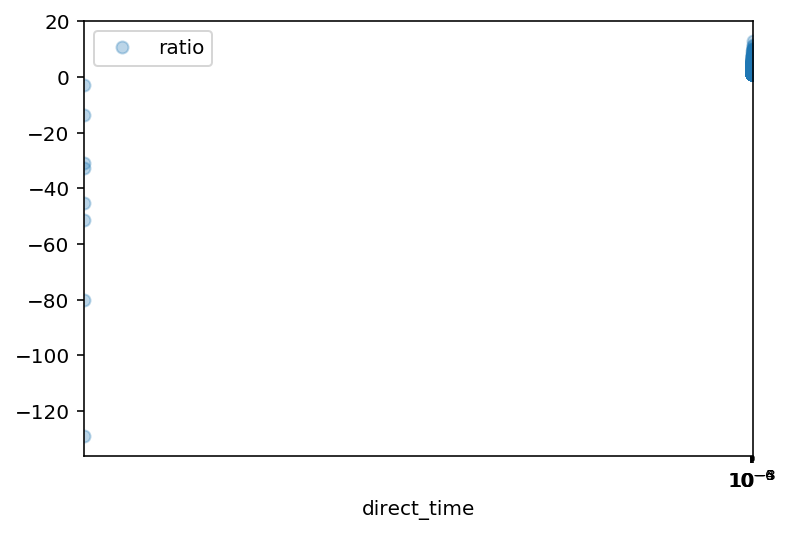

In [9]:
ax = vals.plot(x="direct_time", y="ratio", style="o", alpha=0.3)
ax.set_xscale("log")

In [10]:
vals.direct_time.min()

-0.03404641151428223

(1, 10)

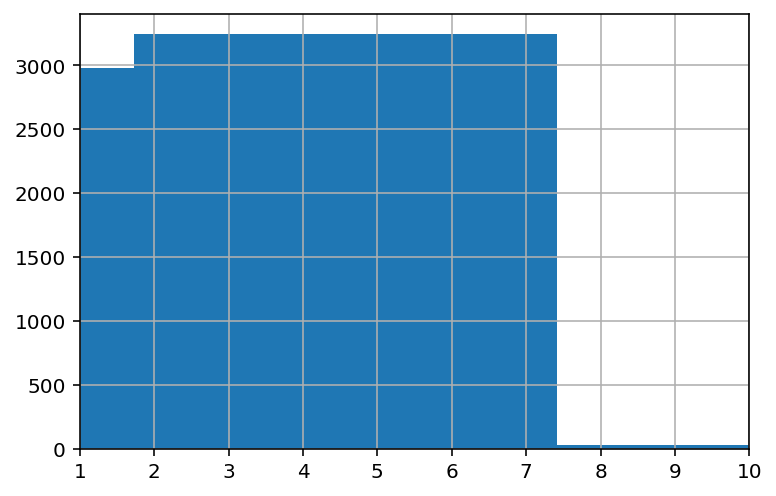

In [11]:
ax = wrong.ratio.hist(bins=25)
ax.set_xlim(1, 10)

**Goal for this histogram:** `ratio.max() < 5` approximately. That's the performance with SciPy 1.3 (again, after un-commenting `_get_constants` above).

In [12]:
(wrong.ratio <= 5).sum() / len(wrong)

0.9819373401534527

Text(0.5, 0, 'log2 ratio')

Text(-3, -0.5, '← FFT faster')

Text(2, -0.5, 'direct faster →')

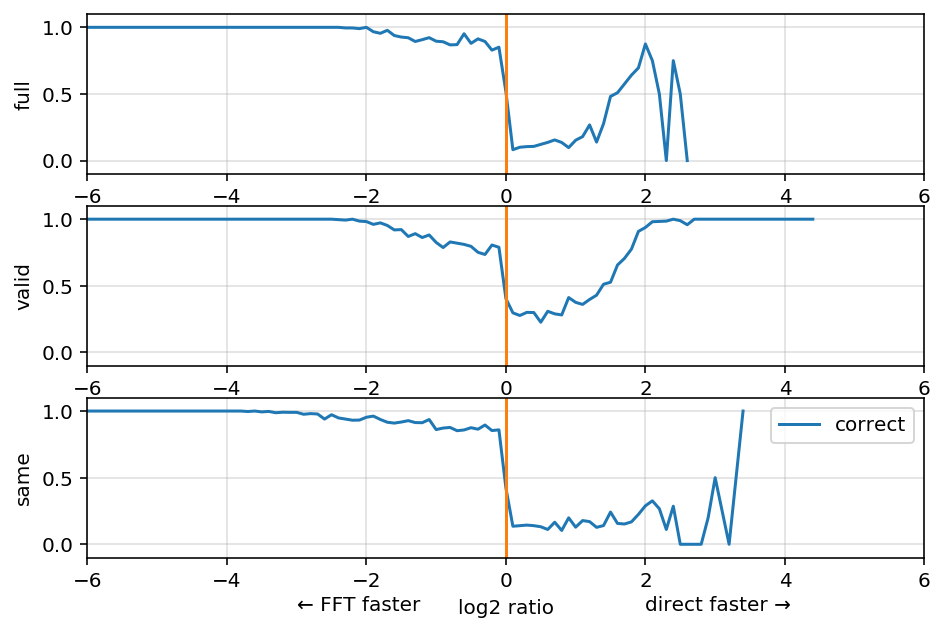

In [21]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)

w = 5
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    correct_predictions = show[show["mode"] == mode].pivot_table(
        index="log_ratio_binned",
        values="correct",
        aggfunc=np.mean
    )
    _ = ax = correct_predictions.plot(ax=ax)
    _ = ax.set_xlim(-6, 6)
    _ = ax.set_ylim(-0.1, 1.1)
    _ = ax.plot([0, 0], ax.get_ylim())
    _ = ax.set_ylabel(mode)
    _ = ax.grid(alpha=0.4)
    if i == 2:
        ax.set_xlabel("log2 ratio")
        ax.text(-3, -0.5, "← FFT faster")
        ax.text(2, -0.5, "direct faster →")
    else:
        ax.legend_.remove()

FFT faster for 89.35% of tests in mode=full
FFT faster for 76.14% of tests in mode=valid
FFT faster for 82.81% of tests in mode=same


Text(0.5, 0, 'number')

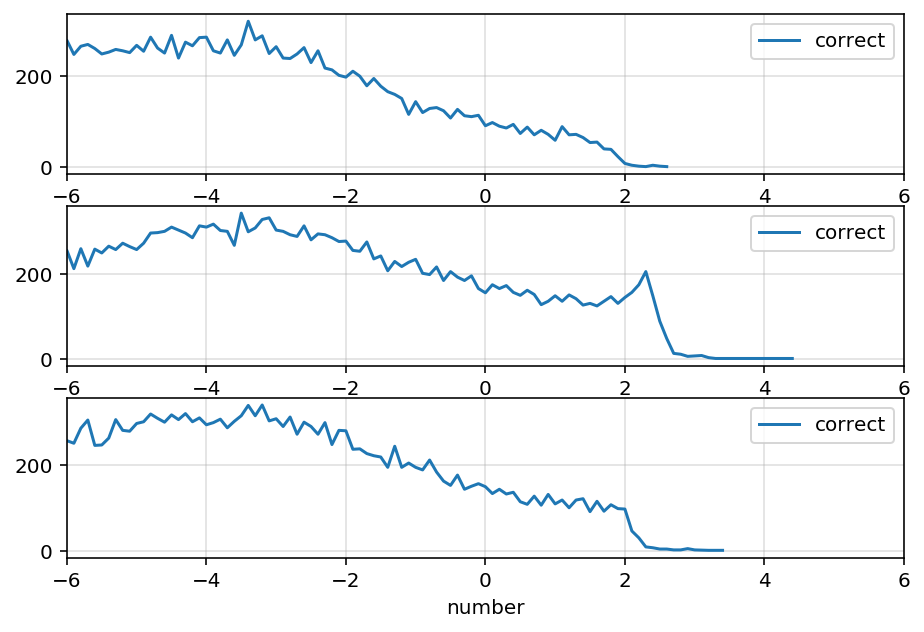

In [29]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)

w = 5
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    s = show[show["mode"] == mode]
    frac_fft_faster = (s.log_ratio < -1).sum() / len(s)
    print(f"FFT >2x faster for {100 * frac_fft_faster:0.2f}% of tests in mode={mode}")
    num = s.pivot_table(
        index="log_ratio_binned",
        values="correct",
        aggfunc=len,
    )
    _ = ax = num.plot(ax=ax)
    _ = ax.set_xlim(-6, 6)
#     _ = ax.set_ylim(-0.1, 1.1)
#     _ = ax.plot([0, 0], ax.get_ylim())
#     _ = ax.set_ylabel(mode)
    _ = ax.grid(alpha=0.4)
    if i == 2:
        ax.set_xlabel("number")
#         ax.text(-3, -0.5, "← FFT faster")
#         ax.text(2, -0.5, "direct faster →")
#     else:
#         ax.legend_.remove()